# diag_btbc_flux

Diagnose barotropic fluxes (and its divergence) and impact of tidal potential:
* compute fluxes
* compute tidal potential work $<gH\vec{\overline{U}}\cdot\vec{\nabla}P_\text{tide}>$ (cf. croco)
* For TPXO8 estimates, see diag_btrop_fluxeb.ipynb

adapted from diag_btrop_fluxeb.ipynb and diag_btrop_flux.ipynb, for paper.


In [1]:
%matplotlib inline
import sys, os, time
from netCDF4 import Dataset, MFDataset

import numpy as np
from matplotlib import pyplot as plt

import scipy.signal as sig
import scipy.ndimage as ndi

In [43]:
# general parameters (although they might be overwritten in some cells)

krypton = "/data0/project/vortex/lahaye/"
ruchba = krypton+"local_ruchba/"
picdir = "pictures/diag_btrop_fluxes/"
dosavefig = True

Ntmax = None   # heritage from previous version
Ntmin = 0
nst = 1
slit = slice(Ntmin, Ntmax, nst)

itbeg, itend = 900, 1020 # for averaging

In [56]:
# load LUCKY's grid

ncgrd = Dataset(krypton+'lucky_corgrd.nc','r')
h = ncgrd.variables['h'][:]
lon_h = ncgrd.variables['lon_rho'][:]
lat_h = ncgrd.variables['lat_rho'][:]
mask = ncgrd.variables['mask_rho'][:]
grang = ncgrd.variables['angle'][:]
pm = ncgrd.variables['pm'][:]
pn = ncgrd.variables['pn'][:]
ncgrd.close()

# load tidal potential from LUCKY's forcing file
ncfrc = Dataset(ruchba+'prep_LUCKYTO/{}_frc.nc'.format(simul))
potamp = ncfrc.variables['tide_Pamp'][0,:,:]
potpha = np.deg2rad(ncfrc.variables['tide_Pphase'][0,:,:])
ncfrc.close()

dx = (1/pm).mean()
dy = (1/pn).mean()

In [62]:
simul = "luckym2"
path_fluxbt = krypton+"DIAG/NRJ_fluxes/{}_btrnrj.?.nc".format(simul)
path_fluxbc = krypton+"DIAG/NRJ_fluxes/{}_bclnrj_M2.?.nc".format(simul)

nc = MFDataset(path_fluxbt, aggdim="eta_rho")
times = nc.variables['scrum_time'][slit]
if nc.variables['scrum_time'].units == "s":
    times /= 3600.
timei = nc.variables['time'][slit]
ebt = np.nanmean(nc.variables['ek_bt'][:,:,slit] + nc.variables['ep_bt'][:,:,slit], axis=(0,1))*1e3 
pu = nc.variables['pu_bt'][:,:,slit]*1e3
pv = nc.variables['pv_bt'][:,:,slit]*1e3
nsx = np.diff(nc.variables['xi_rho'][:2])[0]
nsy = np.diff(nc.variables['eta_rho'][:2])[0]
nc.close()
dxm, dym = dx*nsx, dy*nsy
Ny, Nx, Nt = pu.shape

outfbt = (np.nansum(pu[:,-1,:] - pu[:,0,:], axis=0)/dxm \
          + np.nansum(pv[-1,:,:] - pv[0,:,:], axis=0)/dym) /Nx/Ny
divfbt = np.gradient(pu, dxm, axis=1) + np.gradient(pv, dym, axis=0)
del pu, pv

nc = MFDataset(path_fluxbc, aggdim="eta_rho")
ekbc = np.nanmean(nc.variables['ekint'][:,:,slit] + nc.variables['epint'][:,:,slit], axis=(0,1))*1e3 
pu = nc.variables['puint'][:,:,slit]*1e3
pv = nc.variables['pvint'][:,:,slit]*1e3
nc.close()

outfbc = (np.nansum(pu[:,-1,:] - pu[:,0,:], axis=0)/dxm \
          + np.nansum(pv[-1,:,:] - pv[0,:,:], axis=0)/dym) /Nx/Ny
divfbc = np.gradient(pu, dxm, axis=1) + np.gradient(pv, dym, axis=0)
del pu, pv

dt = (times[1]-times[0])*nst


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid

#### plot time series of mean flux divergence, raw and low pass

In [63]:
fcut = 2*dt/30
bb, aa = sig.butter(4, fcut, btype="low")

mask = np.isfinite(divfbt[:,:,0])
divlbt = sig.filtfilt(bb, aa, divfbt[mask,:], method="gust", axis=-1).mean(axis=0)*1e3

outlbt = sig.filtfilt(bb, aa, outfbt, method="gust", axis=-1)*1e3

mask = np.isfinite(divfbc[:,:,0])
divlbc = sig.filtfilt(bb, aa, divfbc[mask,:], method="gust", axis=-1).mean(axis=0)*1e3

outlbc = sig.filtfilt(bb, aa, outfbc, method="gust", axis=-1)*1e3


divfbt: 5.20 mW/m2  (11.64 GW)
outfbt: 5.16 mW/m2  (11.56 GW)
divfbc: 1.09 mW/m2  (2.44 GW)
outfbc: 1.11 mW/m2  (2.48 GW)


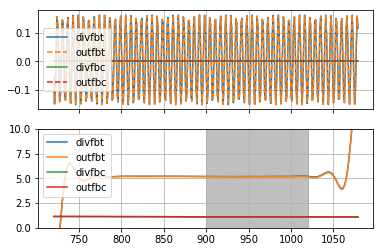

In [64]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False)
ax = axs[0]
ax.plot(times, np.nanmean(divfbt, axis=(0,1)), label="divfbt")
ax.plot(times, outfbt, "--", label="outfbt")
ax.plot(times, np.nanmean(divfbc, axis=(0,1)), label="divfbc")
ax.plot(times, outfbc, "--", label="outfbc")

### filter
ax = axs[1]

ax.plot(times, divlbt, label="divfbt")
ax.plot(times, outlbt, label="outfbt")
ax.plot(times, divlbc, label="divfbc")
ax.plot(times, outlbc, label="outfbc")
ax.set_ylim([0, 10])

for ax in axs:
    ax.grid(True)
    ax.legend()

### print mean values
indt, = np.where((timei>=900) & (timei<=1020))
prov =  divlbt[indt].mean()
print("divfbt: {0:.2f} mW/m2  ({1:.2f} GW)".format(prov, prov/1e3*dxm*dym*(Nx/1e3)*(Ny/1e3)/1e3))
prov =  outlbt[indt].mean()
print("outfbt: {0:.2f} mW/m2  ({1:.2f} GW)".format(prov, prov/1e3*dxm*dym*(Nx/1e3)*(Ny/1e3)/1e3))
prov =  divlbc[indt].mean()
print("divfbc: {0:.2f} mW/m2  ({1:.2f} GW)".format(prov, prov/1e3*dxm*dym*(Nx/1e3)*(Ny/1e3)/1e3))
prov =  outlbc[indt].mean()
print("outfbc: {0:.2f} mW/m2  ({1:.2f} GW)".format(prov, prov/1e3*dxm*dym*(Nx/1e3)*(Ny/1e3)/1e3))

ax.axvspan(times[indt[0]], times[indt[-1]], alpha=0.5, color='gray')

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Ct: 5.58 mW/m2  (12.47 GW)


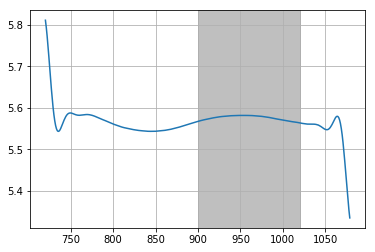

In [75]:
# conversion term -- N.B.: here it's luckym2 vs. lucym2-nopot

nc = MFDataset(path_fluxbt, aggdim="eta_rho")
Cta = nc.variables['Ct_lf'][:] * 1e3 # mW/m^2
nc.close()
mask = np.isfinite(Cta[:,:,0])

plt.plot(times, Cta[mask,:].mean(axis=0))
plt.axvspan(times[indt[0]], times[indt[-1]], alpha=0.5, color='gray')
plt.grid(True)

prov = Cta[mask,:].mean(axis=0)[indt].mean()
print("Ct: {0:.2f} mW/m2  ({1:.2f} GW)".format(prov, prov/1e3*dxm*dym*(mask.sum()/1e6)/1e3))


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


ekbtlf: 0.82 mW/m2  (1.84 GW)
epbtlf: 0.33 mW/m2  (0.75 GW)
etbtlf: 1.16 mW/m2  (2.59 GW)
ekbclf: 1.73 mW/m2  (3.87 GW)
epbclf: 0.82 mW/m2  (1.82 GW)
etbclf: 2.55 mW/m2  (5.70 GW)


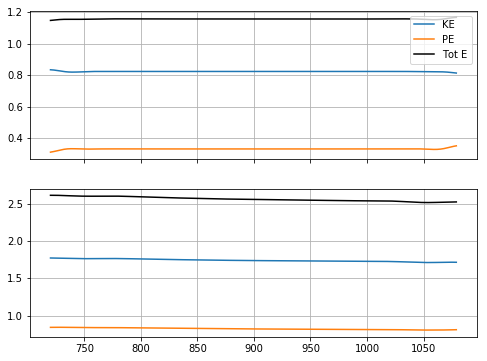

In [87]:
### energy density
#mask = np.isfinite(ebt[:,:,0])
nc = MFDataset(path_fluxbt, aggdim="eta_rho")
prov = np.nanmean(nc.variables['ek_bt'][:,:,slit], axis=(0,1))
ekbtlf = sig.filtfilt(bb, aa, prov, method="gust")
prov = np.nanmean(nc.variables['ep_bt'][:,:,slit], axis=(0,1))
epbtlf = sig.filtfilt(bb, aa, prov, method="gust")
etbtlf = ekbtlf + epbtlf
nc.close()

nc = MFDataset(path_fluxbc, aggdim="eta_rho")
prov = np.nanmean(nc.variables['ekint_lf'][:,:,slit], axis=(0,1))
ekbclf = prov #sig.filtfilt(bb, aa, prov, method="gust")
prov = np.nanmean(nc.variables['epint_lf'][:,:,slit], axis=(0,1))
epbclf = prov #sig.filtfilt(bb, aa, prov, method="gust")
etbclf = ekbclf + epbclf
nc.close()

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
ax = axs[0]
ax.plot(times, ekbtlf, times, epbtlf)
ax.plot(times, etbtlf, color="k")
ax.legend(['KE', 'PE', 'Tot E'])

ax = axs[1]
ax.plot(times, ekbclf, times, epbclf)
ax.plot(times, etbclf, color="k")

for ax in axs:
    ax.grid(True)
    ax.axvspan(times[indt[0]], times[indt[-1]], alpha=0.5, color='gray')

    
for what in ["ekbtlf", "epbtlf", "etbtlf", "ekbclf", "epbclf", "etbclf"]:
    prov = eval(what)[indt].mean()
    print("{2}: {0:.2f} kJ/m2  ({1:.2f} PJ)".format(prov, prov/1e3*dxm*dym*(mask.sum()/1e6)/1e3,what))

In [105]:
# tidal potential: compute its amplitude based on ubar, vbar in simulations
path_2D = krypton+"{0}_tseries/{0}_tseries_2Dvars.nc".format(simul)

# load tidal potential from LUCKY's forcing file
ncfrc = Dataset(ruchba+'prep_LUCKYTO/{}_frc.nc'.format(simul))
potamp = ncfrc.variables['tide_Pamp'][0,:,:]
potpha = np.deg2rad(ncfrc.variables['tide_Pphase'][0,:,:])
period = ncfrc.variables['tide_period'][0] # hours
ncfrc.close()
dpamp_dx = np.gradient(potamp, dx, axis=-1)[:,xi][eta,:]
dpamp_dy = np.gradient(potamp, dy, axis=-2)[:,xi][eta,:]
dphat_dx = np.gradient(potpha, dx, axis=-1)[:,xi][eta,:]
dphat_dy = np.gradient(potpha, dy, axis=-2)[:,xi][eta,:]
potamp = potamp[:,xi][eta,:]
potpha = potpha[:,xi][eta,:]
print("loaded tidal potential information", flush=True)

nc = Dataset(path_2D, "r")
timef = nc.variables['scrum_time'][:]
if nc.variables['scrum_time'].units == "s":
    timef /= 3600  # hours
    
# x-component
ubar = nc.variables['ubar'][:]
mask = np.isfinite(ubar[:,:,0])
theta = 2*np.pi*timef[None,:]/period - potpha[mask,None]
prov = sig.filtfilt(bb, aa, ubar[mask,:]*(dpamp_dx[mask,None]*np.cos(theta) \
                                          + potamp[mask,None]*dphat_dx[mask,None]*np.sin(theta) ), 
                    method="gust", axis=-1)[:,indt]
fpotmap = np.zeros(topo.shape)
fpotmap[mask] = prov.mean(axis=-1) * topo[mask]
fpotser = (prov*topo[mask,None]).mean(axis=0)
print("finished x component")

# y-component
ubar = nc.variables['vbar'][:]
nc.close()
prov = sig.filtfilt(bb, aa, ubar[mask,:]*(dpamp_dy[mask,None]*np.cos(theta) \
                                          + potamp[mask,None]*dphat_dy[mask,None]*np.sin(theta) ), 
                    method="gust", axis=-1)[:,indt]
del ubar
fpotmap[mask] += prov.mean(axis=-1) * topo[mask]
fpotser += (prov*topo[mask,None]).mean(axis=0)
del prov
print("finished y component")

fpotmap *= rho0*grav    # W/m²
fpotser *= rho0*grav

loaded tidal potential information
finished x component
finished y component


Text(0.5,0.98,'Mean potential work: 11.11 mW/m^2 (total: 24.9 GW)')

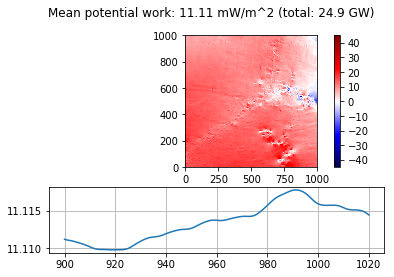

In [119]:
# plot potential work
fig, axs = plt.subplots(2, 1, gridspec_kw={"height_ratios":[2,1]})
ax = axs[0]
hpc = ax.pcolormesh(fpotmap*1e3, cmap='seismic', vmin=-45, vmax=45)
plt.colorbar(hpc, ax=ax)
ax.set_aspect(1)

ax = axs[1]
ax.plot(timef[indt], fpotser*1e3)
ax.grid(True)

fig.suptitle("Mean potential work: {0:.2f} mW/m^2 (total: {1:.1f} GW)".format(\
                        fpotser.mean()*1e3, fpotser.mean()*(mask.sum()/1e6)*dxm*dym/1e3))

